## **CELEB-CNN-MODEL**

**Andrea Gambuzza 1000030561**

La rete neurale è stata progettata per riconoscere il volto delle celebrità presenti nelle immagini.
Come prima cosa bisogna importare le librerie, senza le quali non si ha accesso alle funzioni necessarie per creare e addestrare la rete.


In [1]:
from torchvision.datasets.utils     import download_url
import tarfile #rende possibile la lettura e la scrittura di archivi tar, inclusi quelli che utilizzano la compressione gzip, bz2 e lzma
import zipfile
import torch
import os,os.path
import matplotlib.pyplot            as plt
from PIL                            import Image
import numpy                        as np

from torch.utils.data import DataLoader, SubsetRandomSampler,Subset

import shutil
import gdown

from tqdm                           import tqdm

#PER CONVERTIRE DIRECTORY DI IMMAGINI IN TENSORI
from torchvision.datasets           import ImageFolder
from torchvision.transforms         import ToTensor
from torchvision.transforms         import transforms

#CREAZIONE DEL VALIDATION SET
from torch.utils.data               import random_split
from torch.utils.data               import Subset

#DATALOADER
from torch.utils.data.dataloader    import DataLoader

#MOSTRARE FOTO SLEZIONATE PER BATCH
from torchvision.utils              import make_grid

#PER IMPORTARE LA CLASSE BASE
import torch.nn                       as nn

#CLASSE FUNCTIONAL PER IL CALCOLO DELLA LOSS
import torch.nn.functional           as F

from sklearn.model_selection         import StratifiedShuffleSplit
from sklearn.model_selection         import KFold, train_test_split
from collections                     import Counter

#MATRICE DI CONFUSIONE

from seaborn import heatmap

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

torch.backends.cudnn.benchmark = True #permette di velocizzare l'addestramento
import random


Istanzio le variabili che mi saranno utili successivamente  

In [2]:
old_data_dir = 'C:/Users/lavoro/Desktop/universita/dataMining/lab/progetto/data/105_classes_pins_dataset'
data_dir = 'C:/Users/lavoro/Desktop/universita/dataMining/lab/progetto/data'
augmented_dir = 'C:/Users/lavoro/Desktop/universita/dataMining/lab/progetto/augmented'

nImm1 = 0 #numero immagini iniziale
nImm = 0 # numero immagini dopo la generazione di nuove


prepross = True
DIM = 48 #dimensione immagini 
batchSize = 128

random_seed = 50
torch.manual_seed(random_seed)


PATIENCE = 3
DELTA = 0.01

is_RETRAIN = True
epochs = 20
learningRate = 0.001

onlyTens = True

In [ ]:

dataset_url = "https://storage.googleapis.com/kaggle-data-sets/543939/992580/bundle/archive.zip" #scarica il file nella directory corrente, cifrar10 è un dataset per addestrare e valutare algoritmi di reti neurali (per la classificazione)
download_url(dataset_url, '.') #estrae il file ( libreria tarfile)


### **Preprocessing**

Prima di passare alla fase di addestramento, bisogna aumentare le dimensioni del dataset, in quanto si necessita di un gran numero di immagini su cui svolgere training, validation e test.  
Nel file `augmentation.py` sono state svolte delle trasformazioni, grazie alle quali ho ottenuto un dataset più vario e grande.  
Le seguenti trasformazioni sono state eseguite singolarmente in ogni immagine:

- Resize
- Center crop
- Vertical flip
- Horizontal flip
- Adjust sharpness
- Random rotate
- Gray scale
- Adjust brightness
- Adjust saturation
- Adjust hue
- Gaussian blur
- Color jitter
- Random vertical shift

    

Applico nuovamente la resize in modo da diminuire ancora le dimensioni delle immagini

In [ ]:
for fold in os.listdir(augmented_dir):
    
    path = os.path.join(augmented_dir,fold).replace("\\","/") 
    
    for file in os.listdir(path):
    
        imgPath = os.path.join(path, file)
        img = Image.open(imgPath)
        transform = transforms.Resize((DIM,DIM), interpolation=Image.BICUBIC) # oggetto che uso per applicare la trasformazione
        img = transform(img)
        img.save(os.path.join(path, file))
    
    

Definisco la funzione trasform che mi permetterà di trasformare le immagini in tensori, rendendole utilizzabili dal modello

In [3]:
transform = transforms.Compose([  
    transforms.ToTensor(),
])

In [4]:
dataset = ImageFolder(augmented_dir, transform=transform)
original_data = ImageFolder(data_dir, transform=transform)

In [5]:
data_classes = dataset.classes

n_classes = len(data_classes)

Di seguito vengono messe a confronto le dimensioni del dataset prima dell'augmentation e dopo 

In [6]:
print("Numero di immagini iniziale: ", len(original_data))
print("Numero di immagini dopo la generazione di nuove: ", len(dataset))
print("Numero di classi: ", n_classes)

Numero di immagini iniziale:  3708
Numero di immagini dopo la generazione di nuove:  58630
Numero di classi:  24


Divisione del dataset in trainset e testset, mantenendo la stratificazione delle classi

In [7]:
torch.manual_seed(random_seed)
shuffles = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_seed)

for train_index, test_index in shuffles.split(np.arange(len(dataset)), dataset.targets):
    train_subset= Subset(dataset,train_index)
    test_subset = Subset(dataset,test_index)

In [8]:
print("Numero di immagini nel train set: ", len(train_subset))
print("Numero di immagini nel test set: ", len(test_subset))

Numero di immagini nel train set:  46904
Numero di immagini nel test set:  11726


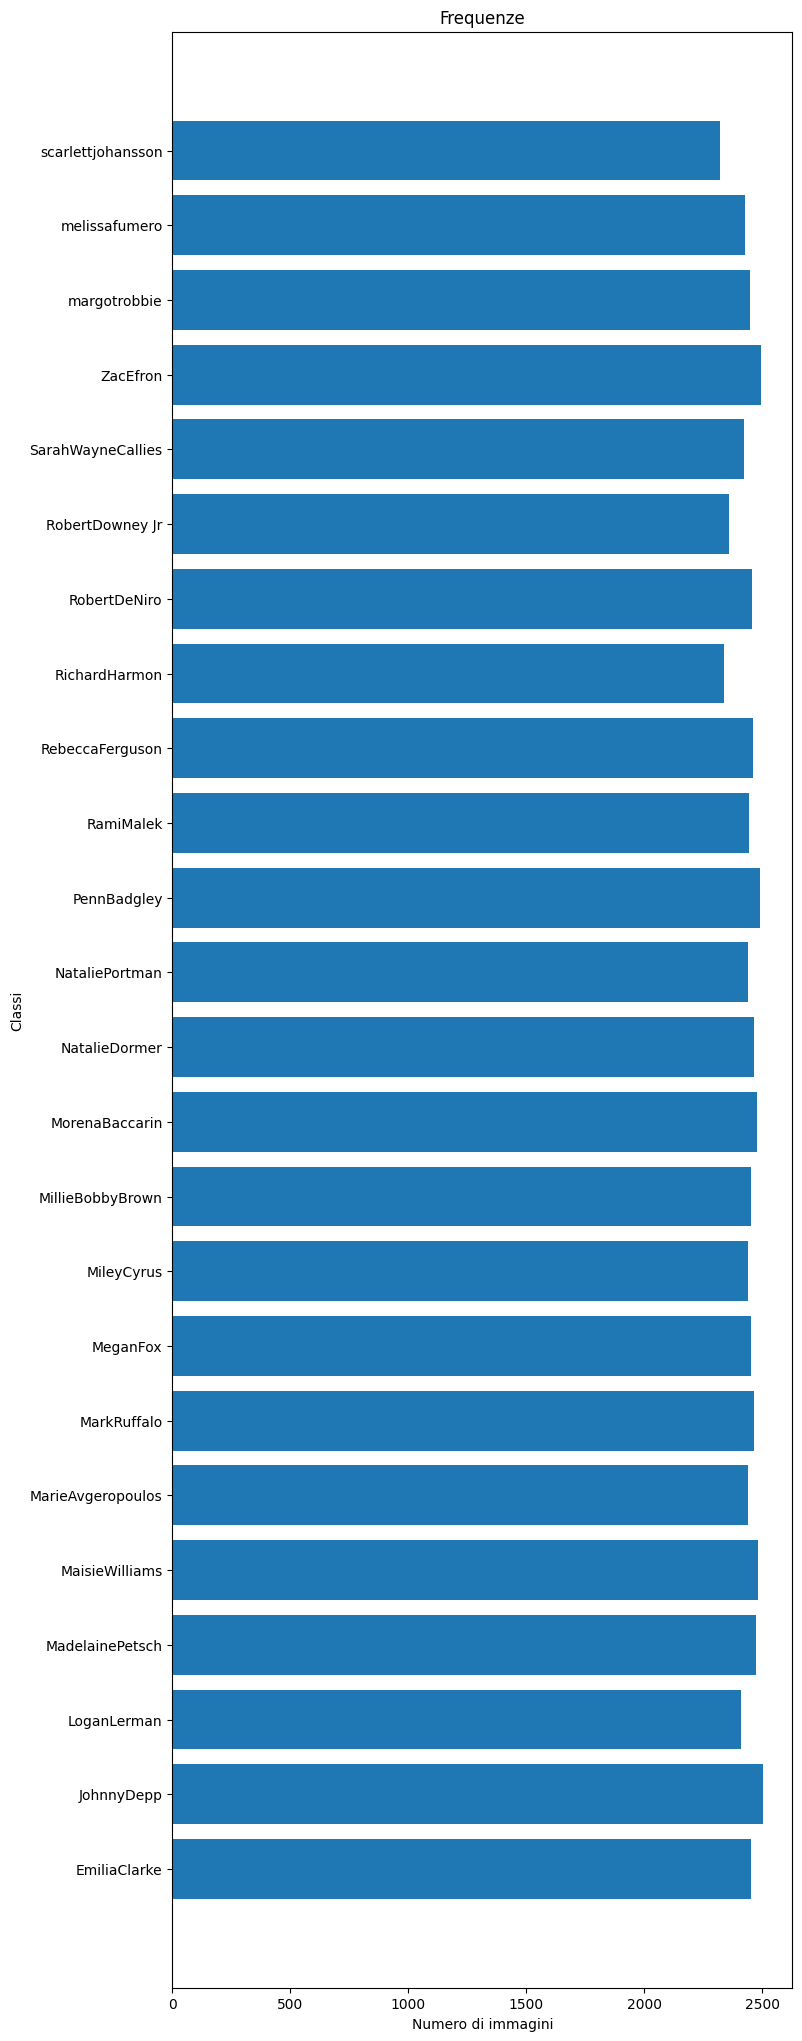

In [9]:
class_counts = Counter(dataset.targets) #torna un dizionario che ha come chiave la classe e come valore il numero di volte che ciascuna classe appare
class_frequency = list(class_counts.values()) #estraggo e converto in una lista le frequezne delle classi 
num_classes = len(class_counts)

fig, ax = plt.subplots(figsize = (8,4))
ax.barh(dataset.classes, class_frequency)
plt.subplots_adjust(top=5.0)
plt.title("Frequenze")
plt.xlabel("Numero di immagini")
plt.ylabel("Classi")

plt.show()



Di seguito viene stampato un batch di esempio

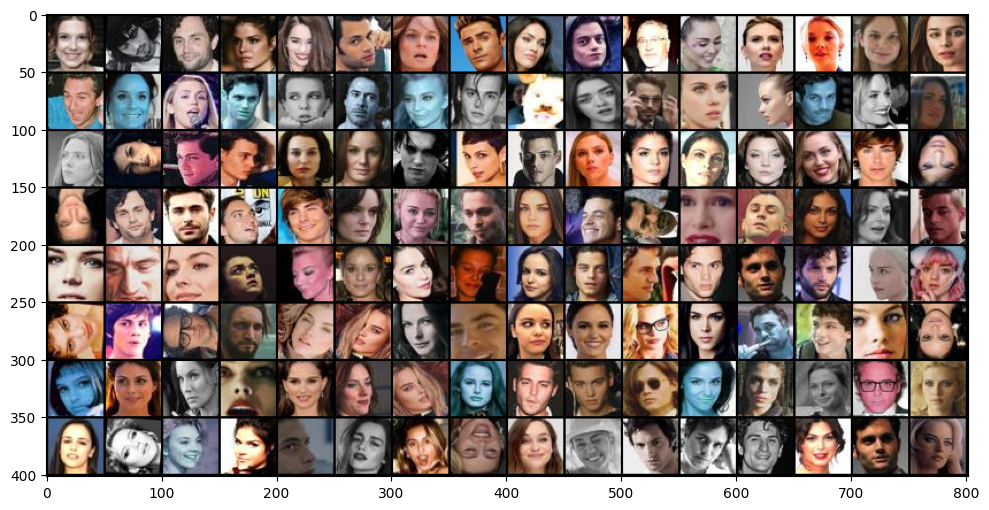

In [10]:
for img, label in DataLoader(train_subset, batchSize, shuffle=True ):
    fig, ax = plt.subplots(figsize = (12,6))
    ax.imshow(make_grid(img,nrow=16).permute(1,2,0))
    break
plt.show()

La funzione to_device è progettata per gestire il trasferimento dei dati tra la CPU e la GPU in modo efficiente. Mentre, la classe DeviceDataloader estende la funzionalità del DataLoader di PyTorch, consentendo di gestire i batch di dati e spostarli direttamente sul dispositivo specificato

In [11]:
def to_device(data,device):
    # Se il dato è una lista o una tupla, la funzione ricorsiva sposta ogni elemento su GPU/CPU
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    # Altrimenti sposta il tensore direttamente
    return data.to(device, non_blocking=True)


class DeviceDataloader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)


device = torch.device("cuda")




I pesi delle classi vengono utilizzati durante l'addestramento della rete neurale per dare maggiore importanza alle classi meno rappresentate

In [12]:
class_weights = [class_frequency[i] / len(dataset) for i in range(len(data_classes))]
class_weights = torch.tensor(class_weights, dtype=torch.float32)


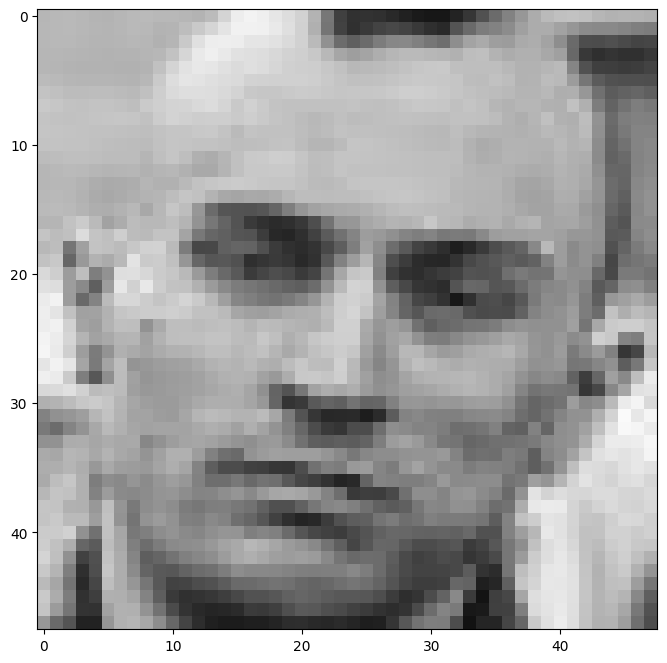

In [13]:

for img, label in train_subset:
    fig, ax = plt.subplots(figsize = (8,14))
    ax.imshow(make_grid(img,nrow=8).permute(1,2,0))
    

    break
plt.show()

#### **La Rete Neurale**

La rete è composta da diversi strati convoluzionali, seguiti da operazioni di pooling e normalizzazione, utili per estrarre caratteristiche complesse dalle immagini. La parte finale della rete è costituita da strati lineari che appiattiscono l'output e lo trasformano in previsioni di classe.

La classe **ResidualBlock** implementa un blocco residuale utilizzato nelle reti neurali profonde, questo contiene un percorso diretto che permette di saltare uno o più layer, aiutando a combattere il problema della scomparsa del gradiente e contiene due convoluzioni con normalizzazione batch e ReLU come attivazione. 

In [14]:
#utilizzo la batchnorm per normalizzare i dati in input perchè
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):#definisce il passaggio in avanti del blocco residuo 
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class celebaCnnModel(nn.Module):
    def __init__(self, num_classes, inchannels):
        super(celebaCnnModel, self).__init__()

        self.ConvNN = nn.Sequential(
            ResidualBlock(inchannels, 16),
            ResidualBlock(16, 64),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(64),
            
            ResidualBlock(64, 128),
            nn.Dropout(0.3),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(128),
            ResidualBlock(128, 256),

            ResidualBlock(256, 512),
            nn.Dropout(0.2),
            nn.MaxPool2d(2,2), 
            nn.BatchNorm2d(512),
            
        )

        self.LinearNN = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        
        x = self.ConvNN(x)
        
        x = self.LinearNN(x)
        return x


La funzione **intialize_weigths_he** è progettata per inizializzare i pesi del modello utilizzando la strategia di He, particolarmente efficace per reti neurali che utilizzano la funzione di attivazione ReLU

In [15]:
#inizializzazione pesi del modello 
def intialize_weigths_he(model):
    for layer in model.modules():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu') #inizializza i pesi con una distribuzione normale 
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0.0)  

#### **Fase di training**

La funzione **train_and_validate** gestisce l'addestramento e la validazione del modello di rete neurale utilizzando la tecnica di K-fold cross-validation. Questa funzione rincipale chiama al suo interno le funzioni **training** e **validate**. 

Per ogni epoca, il modello viene messo in modalità di addestramento, e si calcola la perdita media e l'accuratezza per il training. Successivamente, il modello viene messo in modalità di valutazione per calcolare la perdita e l'accuratezza di validazione.

I risultati delle perdite e delle accuratezze di addestramento e validazione vengono salvati per ogni epoca. Se non ci sono miglioramenti significativi nella perdita di validazione, viene attivato l'early stopping per interrompere l'addestramento.



In [16]:
def training(model, optimizer, train_dl, loss_func, epochs, epoch, all_train_losses_fold, all_train_accuracies_fold):
    model.train()
    running_loss = 0.0
    train_correct = 0.0
    t_total = 0.0            

    train_loader_tqdm = tqdm(train_dl, desc=f"Training Epoch {epoch + 1}/{epochs}", unit="batch")
    for inputs, labels in train_loader_tqdm:
        optimizer.zero_grad()
        t_outputs = model(inputs)
        loss = loss_func(t_outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        t_total += labels.size(0)
        _, predicted = torch.max(t_outputs, 1)
        train_correct += (predicted == labels).sum().item()

    train_average_loss = running_loss / len(train_dl) 
    train_acc = 100 * train_correct / t_total

    print(f'Training Loss: {train_average_loss}, Accuracy: {train_acc}%')

    all_train_losses_fold.append(train_average_loss)
    all_train_accuracies_fold.append(train_acc)
    

def validate(model, val_dl, loss_func, epochs, epoch):
    model.eval()
    validation_loss = 0.0
    val_correct = 0
    v_total = 0

    val_loader_tqdm = tqdm(val_dl, desc=f"Validation Epoch {epoch + 1}/{epochs}", unit="batch")
    all_labels = []  # Lista per le etichette vere
    all_predictions = []  # Lista per le predizioni

    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            v_outputs = model(inputs)
            loss = loss_func(v_outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(v_outputs, 1)

            all_labels.extend(labels.cpu().numpy())  # Aggiungi le etichette vere
            all_predictions.extend(predicted.cpu().numpy())  # Aggiungi le predizioni

            v_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_average_loss = validation_loss / len(val_dl)
    val_acc = 100 * val_correct / v_total

    print(f'Validation Loss: {val_average_loss}, Accuracy: {val_acc}%')
    print("____________________________________________________")
    return val_average_loss, val_acc, all_labels, all_predictions


**L'earlyStopping** serve a interrompere l'addestramento del modello se non si osservano miglioramenti significativi nella perdita di validazione per un numero specificato di epoche (patience), 3 in questo caso. 

In [17]:
def train_and_validate(model_class, dataset, loss_func, learning_rate, epochs, is_RETRAIN, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=random_seed)
    

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f'Fold {fold + 1}/{k}')
        
        y_true_fold = []
        y_pred_fold = []
        all_train_losses_fold = []
        all_val_losses_fold = []
        all_train_accuracies_fold = []
        all_val_accuracies_fold = []

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        train_dl = DataLoader(train_subset, batch_size=batchSize, shuffle=True, num_workers=4, pin_memory=True)
        train_dl = DeviceDataloader(train_dl, device)
        val_dl = DataLoader(val_subset, batch_size=batchSize, shuffle=False, num_workers=4, pin_memory=True)
        val_dl = DeviceDataloader(val_dl, device)

        model = model_class(num_classes=len(classes), inchannels=3) 
        if is_RETRAIN:
            intialize_weigths_he(model)
        else:
            model.load_state_dict(torch.load("model_weights.pth"))
        
        model = to_device(model, device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 7, gamma=0.1)

        loss_history = []
        patient_counter = 0
        for epoch in range(epochs):
            training(model=model, optimizer=optimizer, loss_func=loss_func, train_dl=train_dl, epochs=epochs, epoch=epoch, all_train_losses_fold=all_train_losses_fold, all_train_accuracies_fold=all_train_accuracies_fold)

            val_loss_epoch, val_acc_epoch, labels, predicted = validate(model=model, val_dl=val_dl, loss_func=loss_func, epochs=epochs, epoch=epoch)
            loss_history.append(val_loss_epoch)
            
            if fold == 0:  # Se siamo nel primo fold
                y_true_fold.extend(labels)
                y_pred_fold.extend(predicted)

                all_val_losses_fold.append(val_loss_epoch)
                all_val_accuracies_fold.append(val_acc_epoch)

            # Early stopping
            if len(loss_history) > 1:
                if loss_history[-2] - loss_history[-1] < DELTA:
                    patient_counter += 1
                else:  
                    patient_counter = 0
                
            if patient_counter >= PATIENCE:
                print("Early stopping attivato")
                break

            scheduler.step()

    # Salva i risultati di un fold
        np.save(f"true_labels_fold{fold}.npy", np.array(y_true_fold)) 
        np.save(f"predicted_labels_fold{fold}.npy", np.array(y_pred_fold))
        np.save(f"train_losses_fold{fold}.npy", np.array(all_train_losses_fold))
        np.save(f"val_losses_fold{fold}.npy", np.array(all_val_losses_fold))
        np.save(f"train_accuracies_fold{fold}.npy", np.array(all_train_accuracies_fold))
        np.save(f"val_accuracies_fold{fold}.npy", np.array(all_val_accuracies_fold))

    return model


Si avvia il modello e si salva nella variabile model, in modo da poter essere caricato successivamente

In [25]:
#versione finale
loss_func = nn.CrossEntropyLoss(class_weights.to(device))
model= train_and_validate(model_class=celebaCnnModel, dataset=train_subset, loss_func=loss_func, learning_rate=learningRate ,epochs=epochs, is_RETRAIN=is_RETRAIN, classes=data_classes) 


Fold 1/5


Training Epoch 1/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 2.7628861503536197, Accuracy: 19.236201796231644%


Validation Epoch 1/20: 100%|██████████| 74/74 [00:32<00:00,  2.29batch/s]


Validation Loss: 2.095307356602437, Accuracy: 37.74650890097005%
____________________________________________________


Training Epoch 2/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 1.4656682866973942, Accuracy: 55.59256989046718%


Validation Epoch 2/20: 100%|██████████| 74/74 [00:32<00:00,  2.26batch/s]


Validation Loss: 1.3235906298096116, Accuracy: 59.04487794478201%
____________________________________________________


Training Epoch 3/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.8479346677559574, Accuracy: 74.70884524158517%


Validation Epoch 3/20: 100%|██████████| 74/74 [00:32<00:00,  2.26batch/s]


Validation Loss: 0.8677813579907289, Accuracy: 75.30114060334719%
____________________________________________________


Training Epoch 4/20: 100%|██████████| 294/294 [01:44<00:00,  2.81batch/s]


Training Loss: 0.6607649845330894, Accuracy: 80.03357940463182%


Validation Epoch 4/20: 100%|██████████| 74/74 [00:35<00:00,  2.08batch/s]


Validation Loss: 0.9036740282097379, Accuracy: 72.7214582667093%
____________________________________________________


Training Epoch 5/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.567835370800933, Accuracy: 82.74658209631426%


Validation Epoch 5/20: 100%|██████████| 74/74 [00:35<00:00,  2.08batch/s]


Validation Loss: 0.6773604488856083, Accuracy: 80.86557936254131%
____________________________________________________


Training Epoch 6/20: 100%|██████████| 294/294 [01:43<00:00,  2.84batch/s]


Training Loss: 0.5053149670565209, Accuracy: 84.39623697465555%


Validation Epoch 6/20: 100%|██████████| 74/74 [00:36<00:00,  2.03batch/s]


Validation Loss: 0.6588702693178847, Accuracy: 81.01481718366912%
____________________________________________________


Training Epoch 7/20: 100%|██████████| 294/294 [01:44<00:00,  2.82batch/s]


Training Loss: 0.43859021522763636, Accuracy: 86.34704048183781%


Validation Epoch 7/20: 100%|██████████| 74/74 [00:35<00:00,  2.07batch/s]


Validation Loss: 0.6535627624473056, Accuracy: 80.83359982944249%
____________________________________________________


Training Epoch 8/20: 100%|██████████| 294/294 [01:44<00:00,  2.82batch/s]


Training Loss: 0.204054925692122, Accuracy: 94.0383231617941%


Validation Epoch 8/20: 100%|██████████| 74/74 [00:35<00:00,  2.11batch/s]


Validation Loss: 0.42335136375717214, Accuracy: 87.52798209146147%
____________________________________________________


Training Epoch 9/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.11497784865906044, Accuracy: 96.78597127095381%


Validation Epoch 9/20: 100%|██████████| 74/74 [00:33<00:00,  2.22batch/s]


Validation Loss: 0.400200833742683, Accuracy: 88.00767508794371%
____________________________________________________


Training Epoch 10/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 0.0810876169628432, Accuracy: 97.89728966234043%


Validation Epoch 10/20: 100%|██████████| 74/74 [00:35<00:00,  2.08batch/s]


Validation Loss: 0.38484367023448685, Accuracy: 88.67924528301887%
____________________________________________________


Training Epoch 11/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.05682620243327755, Accuracy: 98.63283852570423%


Validation Epoch 11/20: 100%|██████████| 74/74 [00:32<00:00,  2.24batch/s]


Validation Loss: 0.39215415293300476, Accuracy: 88.64726574992005%
____________________________________________________


Training Epoch 12/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 0.0422840074502996, Accuracy: 99.09921914559071%


Validation Epoch 12/20: 100%|██████████| 74/74 [00:35<00:00,  2.11batch/s]


Validation Loss: 0.38578325187837753, Accuracy: 88.87112248161176%
____________________________________________________


Training Epoch 13/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.03582022944306892, Accuracy: 99.30975668256802%


Validation Epoch 13/20: 100%|██████████| 74/74 [00:33<00:00,  2.20batch/s]


Validation Loss: 0.3834061870301092, Accuracy: 88.67924528301887%
____________________________________________________
Early stopping attivato
Fold 2/5


Training Epoch 1/20: 100%|██████████| 294/294 [01:44<00:00,  2.82batch/s]


Training Loss: 2.663496348322654, Accuracy: 22.119766543186845%


Validation Epoch 1/20: 100%|██████████| 74/74 [00:35<00:00,  2.11batch/s]


Validation Loss: 1.9624783251736615, Accuracy: 41.29623707493871%
____________________________________________________


Training Epoch 2/20: 100%|██████████| 294/294 [01:42<00:00,  2.88batch/s]


Training Loss: 1.3941038451632675, Accuracy: 57.71127042080857%


Validation Epoch 2/20: 100%|██████████| 74/74 [00:32<00:00,  2.27batch/s]


Validation Loss: 1.0458760551504187, Accuracy: 70.54685001598976%
____________________________________________________


Training Epoch 3/20: 100%|██████████| 294/294 [01:43<00:00,  2.84batch/s]


Training Loss: 0.836979425784682, Accuracy: 75.00999387042614%


Validation Epoch 3/20: 100%|██████████| 74/74 [00:29<00:00,  2.49batch/s]


Validation Loss: 0.7927287857274752, Accuracy: 77.39047009913655%
____________________________________________________


Training Epoch 4/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 0.6415269553255872, Accuracy: 80.43599925379101%


Validation Epoch 4/20: 100%|██████████| 74/74 [00:36<00:00,  2.05batch/s]


Validation Loss: 0.7048913598866076, Accuracy: 79.59705788295491%
____________________________________________________


Training Epoch 5/20: 100%|██████████| 294/294 [01:43<00:00,  2.84batch/s]


Training Loss: 0.5558130822214139, Accuracy: 83.0743810462916%


Validation Epoch 5/20: 100%|██████████| 74/74 [00:35<00:00,  2.11batch/s]


Validation Loss: 0.6710249688979741, Accuracy: 81.19603453789574%
____________________________________________________


Training Epoch 6/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 0.5040262010024519, Accuracy: 84.6813954108147%


Validation Epoch 6/20: 100%|██████████| 74/74 [00:36<00:00,  2.03batch/s]


Validation Loss: 0.6258310695757737, Accuracy: 82.26201897452297%
____________________________________________________


Training Epoch 7/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.44070176982960735, Accuracy: 86.45097673426964%


Validation Epoch 7/20: 100%|██████████| 74/74 [00:35<00:00,  2.10batch/s]


Validation Loss: 0.5777757280581707, Accuracy: 83.50922076537682%
____________________________________________________


Training Epoch 8/20: 100%|██████████| 294/294 [01:42<00:00,  2.85batch/s]


Training Loss: 0.2103885016245704, Accuracy: 93.73983956506676%


Validation Epoch 8/20: 100%|██████████| 74/74 [00:32<00:00,  2.29batch/s]


Validation Loss: 0.4088607408307694, Accuracy: 88.00767508794371%
____________________________________________________


Training Epoch 9/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 0.11953599268228424, Accuracy: 96.62073927990832%


Validation Epoch 9/20: 100%|██████████| 74/74 [00:33<00:00,  2.22batch/s]


Validation Loss: 0.39189884388769, Accuracy: 88.39142948512952%
____________________________________________________


Training Epoch 10/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.08291118514096858, Accuracy: 97.77736321722676%


Validation Epoch 10/20: 100%|██████████| 74/74 [00:32<00:00,  2.27batch/s]


Validation Loss: 0.3851338723624075, Accuracy: 88.79650357104786%
____________________________________________________


Training Epoch 11/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.06134777642837187, Accuracy: 98.51291208059057%


Validation Epoch 11/20: 100%|██████████| 74/74 [00:32<00:00,  2.25batch/s]


Validation Loss: 0.37550625849414515, Accuracy: 89.11629890203604%
____________________________________________________


Training Epoch 12/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.044531789396059555, Accuracy: 99.01393811795432%


Validation Epoch 12/20: 100%|██████████| 74/74 [00:33<00:00,  2.23batch/s]


Validation Loss: 0.3780110822738828, Accuracy: 88.9350815478094%
____________________________________________________
Early stopping attivato
Fold 3/5


Training Epoch 1/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 2.7349567076786845, Accuracy: 19.46006449377715%


Validation Epoch 1/20: 100%|██████████| 74/74 [00:34<00:00,  2.12batch/s]


Validation Loss: 2.064588752952782, Accuracy: 39.05766975802153%
____________________________________________________


Training Epoch 2/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 1.4642481282860242, Accuracy: 55.74181168883085%


Validation Epoch 2/20: 100%|██████████| 74/74 [00:33<00:00,  2.24batch/s]


Validation Loss: 1.147531807422638, Accuracy: 68.74533631808976%
____________________________________________________


Training Epoch 3/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.8436036330907524, Accuracy: 74.85808703994883%


Validation Epoch 3/20: 100%|██████████| 74/74 [00:32<00:00,  2.25batch/s]


Validation Loss: 0.8103608408489743, Accuracy: 77.25189212237501%
____________________________________________________


Training Epoch 4/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.6598195512684024, Accuracy: 80.38003357940462%


Validation Epoch 4/20: 100%|██████████| 74/74 [00:32<00:00,  2.26batch/s]


Validation Loss: 0.7059901199630789, Accuracy: 79.87421383647799%
____________________________________________________


Training Epoch 5/20: 100%|██████████| 294/294 [01:44<00:00,  2.82batch/s]


Training Loss: 0.5716019301187425, Accuracy: 82.70660661460971%


Validation Epoch 5/20: 100%|██████████| 74/74 [00:35<00:00,  2.06batch/s]


Validation Loss: 0.6668392210393339, Accuracy: 80.01279181323953%
____________________________________________________


Training Epoch 6/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.4999747555069372, Accuracy: 84.72137089251926%


Validation Epoch 6/20: 100%|██████████| 74/74 [00:32<00:00,  2.28batch/s]


Validation Loss: 0.6271307520769738, Accuracy: 82.20871975269161%
____________________________________________________


Training Epoch 7/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.45223588319051833, Accuracy: 86.28574474322416%


Validation Epoch 7/20: 100%|██████████| 74/74 [00:32<00:00,  2.25batch/s]


Validation Loss: 0.5954240081278054, Accuracy: 82.76303165973776%
____________________________________________________


Training Epoch 8/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.20094416409629542, Accuracy: 94.2035551528396%


Validation Epoch 8/20: 100%|██████████| 74/74 [00:33<00:00,  2.21batch/s]


Validation Loss: 0.39582798448768824, Accuracy: 88.31681057456561%
____________________________________________________


Training Epoch 9/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 0.1101875028756707, Accuracy: 96.96985848679476%


Validation Epoch 9/20: 100%|██████████| 74/74 [00:34<00:00,  2.13batch/s]


Validation Loss: 0.3746788656792125, Accuracy: 89.03102014710585%
____________________________________________________


Training Epoch 10/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.07530759553722784, Accuracy: 98.17178797004505%


Validation Epoch 10/20: 100%|██████████| 74/74 [00:33<00:00,  2.23batch/s]


Validation Loss: 0.3674468887416092, Accuracy: 89.25487687879757%
____________________________________________________


Training Epoch 11/20: 100%|██████████| 294/294 [01:43<00:00,  2.84batch/s]


Training Loss: 0.05371487866073441, Accuracy: 98.89401167284066%


Validation Epoch 11/20: 100%|██████████| 74/74 [00:35<00:00,  2.07batch/s]


Validation Loss: 0.35872451900630387, Accuracy: 89.23355719006503%
____________________________________________________


Training Epoch 12/20: 100%|██████████| 294/294 [01:41<00:00,  2.88batch/s]


Training Loss: 0.03991268430899854, Accuracy: 99.24846094395437%


Validation Epoch 12/20: 100%|██████████| 74/74 [00:33<00:00,  2.24batch/s]


Validation Loss: 0.3547362779846063, Accuracy: 89.61731158725082%
____________________________________________________
Early stopping attivato
Fold 4/5


Training Epoch 1/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 2.615117976860124, Accuracy: 23.343016283346213%


Validation Epoch 1/20: 100%|██████████| 74/74 [00:37<00:00,  1.96batch/s]


Validation Loss: 1.8866727223267425, Accuracy: 42.57541839889138%
____________________________________________________


Training Epoch 2/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 1.2825598007156735, Accuracy: 61.415665058763956%


Validation Epoch 2/20: 100%|██████████| 74/74 [00:34<00:00,  2.12batch/s]


Validation Loss: 0.9213404752112724, Accuracy: 73.31840955122055%
____________________________________________________


Training Epoch 3/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.8029198222825317, Accuracy: 76.09466194067639%


Validation Epoch 3/20: 100%|██████████| 74/74 [00:32<00:00,  2.28batch/s]


Validation Loss: 0.7836586132242873, Accuracy: 77.03869523504957%
____________________________________________________


Training Epoch 4/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.6175944491916773, Accuracy: 81.44871145697306%


Validation Epoch 4/20: 100%|██████████| 74/74 [00:33<00:00,  2.20batch/s]


Validation Loss: 0.6936121091649339, Accuracy: 79.7889350815478%
____________________________________________________


Training Epoch 5/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 0.546817888410724, Accuracy: 83.27958851904165%


Validation Epoch 5/20: 100%|██████████| 74/74 [00:37<00:00,  1.96batch/s]


Validation Loss: 0.6121994192535812, Accuracy: 82.26201897452297%
____________________________________________________


Training Epoch 6/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.4865543904657267, Accuracy: 85.07848519574661%


Validation Epoch 6/20: 100%|██████████| 74/74 [00:35<00:00,  2.09batch/s]


Validation Loss: 0.5833041486707894, Accuracy: 82.96556870269694%
____________________________________________________


Training Epoch 7/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.4373597761197966, Accuracy: 86.48562215174692%


Validation Epoch 7/20: 100%|██████████| 74/74 [00:37<00:00,  1.96batch/s]


Validation Loss: 0.6210232123329833, Accuracy: 81.96354333226735%
____________________________________________________


Training Epoch 8/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.1969390312830607, Accuracy: 94.24886069877142%


Validation Epoch 8/20: 100%|██████████| 74/74 [00:33<00:00,  2.21batch/s]


Validation Loss: 0.3819751932814315, Accuracy: 88.7432043492165%
____________________________________________________


Training Epoch 9/20: 100%|██████████| 294/294 [01:41<00:00,  2.89batch/s]


Training Loss: 0.11284965218431285, Accuracy: 96.83927191322655%


Validation Epoch 9/20: 100%|██████████| 74/74 [00:31<00:00,  2.32batch/s]


Validation Loss: 0.35933716977770264, Accuracy: 89.32949578936147%
____________________________________________________


Training Epoch 10/20: 100%|██████████| 294/294 [01:42<00:00,  2.88batch/s]


Training Loss: 0.07754115521793767, Accuracy: 97.88396450177224%


Validation Epoch 10/20: 100%|██████████| 74/74 [00:32<00:00,  2.31batch/s]


Validation Loss: 0.34981699690625473, Accuracy: 89.69193049781474%
____________________________________________________


Training Epoch 11/20: 100%|██████████| 294/294 [01:42<00:00,  2.88batch/s]


Training Loss: 0.055048425099020505, Accuracy: 98.76609013138608%


Validation Epoch 11/20: 100%|██████████| 74/74 [00:32<00:00,  2.30batch/s]


Validation Loss: 0.33973794792954987, Accuracy: 89.74522971964609%
____________________________________________________


Training Epoch 12/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 0.041674621523592345, Accuracy: 99.1498547557498%


Validation Epoch 12/20: 100%|██████████| 74/74 [00:32<00:00,  2.30batch/s]


Validation Loss: 0.3423931294599095, Accuracy: 89.78786909711118%
____________________________________________________


Training Epoch 13/20: 100%|██████████| 294/294 [01:41<00:00,  2.90batch/s]


Training Loss: 0.03414190041382804, Accuracy: 99.3870426138635%


Validation Epoch 13/20: 100%|██████████| 74/74 [00:32<00:00,  2.28batch/s]


Validation Loss: 0.3406972647518725, Accuracy: 89.96908645133782%
____________________________________________________


Training Epoch 14/20: 100%|██████████| 294/294 [01:41<00:00,  2.90batch/s]


Training Loss: 0.03066198494234661, Accuracy: 99.4669935772726%


Validation Epoch 14/20: 100%|██████████| 74/74 [00:32<00:00,  2.30batch/s]


Validation Loss: 0.3339751034572318, Accuracy: 90.17162349429698%
____________________________________________________
Early stopping attivato
Fold 5/5


Training Epoch 1/20: 100%|██████████| 294/294 [01:45<00:00,  2.80batch/s]


Training Loss: 2.639662086152706, Accuracy: 22.697473616885194%


Validation Epoch 1/20: 100%|██████████| 74/74 [00:34<00:00,  2.12batch/s]


Validation Loss: 1.8721342199557536, Accuracy: 41.940298507462686%
____________________________________________________


Training Epoch 2/20: 100%|██████████| 294/294 [01:42<00:00,  2.88batch/s]


Training Loss: 1.3089212031186033, Accuracy: 60.60121522225776%


Validation Epoch 2/20: 100%|██████████| 74/74 [00:31<00:00,  2.32batch/s]


Validation Loss: 0.9096937799775923, Accuracy: 74.09381663113007%
____________________________________________________


Training Epoch 3/20: 100%|██████████| 294/294 [01:42<00:00,  2.88batch/s]


Training Loss: 0.7869055814483539, Accuracy: 76.59098177166614%


Validation Epoch 3/20: 100%|██████████| 74/74 [00:32<00:00,  2.29batch/s]


Validation Loss: 0.8791733698264973, Accuracy: 74.81876332622602%
____________________________________________________


Training Epoch 4/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.6363960825869827, Accuracy: 80.56976868137725%


Validation Epoch 4/20: 100%|██████████| 74/74 [00:32<00:00,  2.31batch/s]


Validation Loss: 0.6524837746008022, Accuracy: 80.73560767590618%
____________________________________________________


Training Epoch 5/20: 100%|██████████| 294/294 [01:42<00:00,  2.88batch/s]


Training Loss: 0.5481238000246943, Accuracy: 83.21607504530434%


Validation Epoch 5/20: 100%|██████████| 74/74 [00:32<00:00,  2.29batch/s]


Validation Loss: 0.8200668966447985, Accuracy: 76.00213219616205%
____________________________________________________


Training Epoch 6/20: 100%|██████████| 294/294 [01:42<00:00,  2.86batch/s]


Training Loss: 0.49336258327068927, Accuracy: 84.729772945315%


Validation Epoch 6/20: 100%|██████████| 74/74 [00:32<00:00,  2.28batch/s]


Validation Loss: 0.5651758560860479, Accuracy: 83.61407249466951%
____________________________________________________


Training Epoch 7/20: 100%|██████████| 294/294 [01:41<00:00,  2.88batch/s]


Training Loss: 0.4364476330122169, Accuracy: 86.46199765483424%


Validation Epoch 7/20: 100%|██████████| 74/74 [00:32<00:00,  2.24batch/s]


Validation Loss: 0.5194020126316998, Accuracy: 84.66950959488273%
____________________________________________________


Training Epoch 8/20: 100%|██████████| 294/294 [01:42<00:00,  2.88batch/s]


Training Loss: 0.20296961996628313, Accuracy: 94.08112141562734%


Validation Epoch 8/20: 100%|██████████| 74/74 [00:31<00:00,  2.32batch/s]


Validation Loss: 0.37892965529416056, Accuracy: 88.61407249466951%
____________________________________________________


Training Epoch 9/20: 100%|██████████| 294/294 [01:43<00:00,  2.85batch/s]


Training Loss: 0.11316638776943796, Accuracy: 96.85268095085812%


Validation Epoch 9/20: 100%|██████████| 74/74 [00:32<00:00,  2.28batch/s]


Validation Loss: 0.3621460707807863, Accuracy: 89.1044776119403%
____________________________________________________


Training Epoch 10/20: 100%|██████████| 294/294 [01:42<00:00,  2.85batch/s]


Training Loss: 0.07652488946091054, Accuracy: 98.04924848097218%


Validation Epoch 10/20: 100%|██████████| 74/74 [00:32<00:00,  2.27batch/s]


Validation Loss: 0.35612996466256475, Accuracy: 89.27505330490405%
____________________________________________________


Training Epoch 11/20: 100%|██████████| 294/294 [01:42<00:00,  2.87batch/s]


Training Loss: 0.052033008412033524, Accuracy: 98.89137618590769%


Validation Epoch 11/20: 100%|██████████| 74/74 [00:32<00:00,  2.31batch/s]


Validation Loss: 0.3553742435131524, Accuracy: 89.23240938166312%
____________________________________________________


Training Epoch 12/20: 100%|██████████| 294/294 [01:42<00:00,  2.88batch/s]


Training Loss: 0.03863518687636674, Accuracy: 99.27246562200192%


Validation Epoch 12/20: 100%|██████████| 74/74 [00:32<00:00,  2.29batch/s]

Validation Loss: 0.3455678121866407, Accuracy: 89.7547974413646%
____________________________________________________
Early stopping attivato


Di seguito viene generate la matrice di confusione, che permette di rappresentare l'accuratezza della classificazione

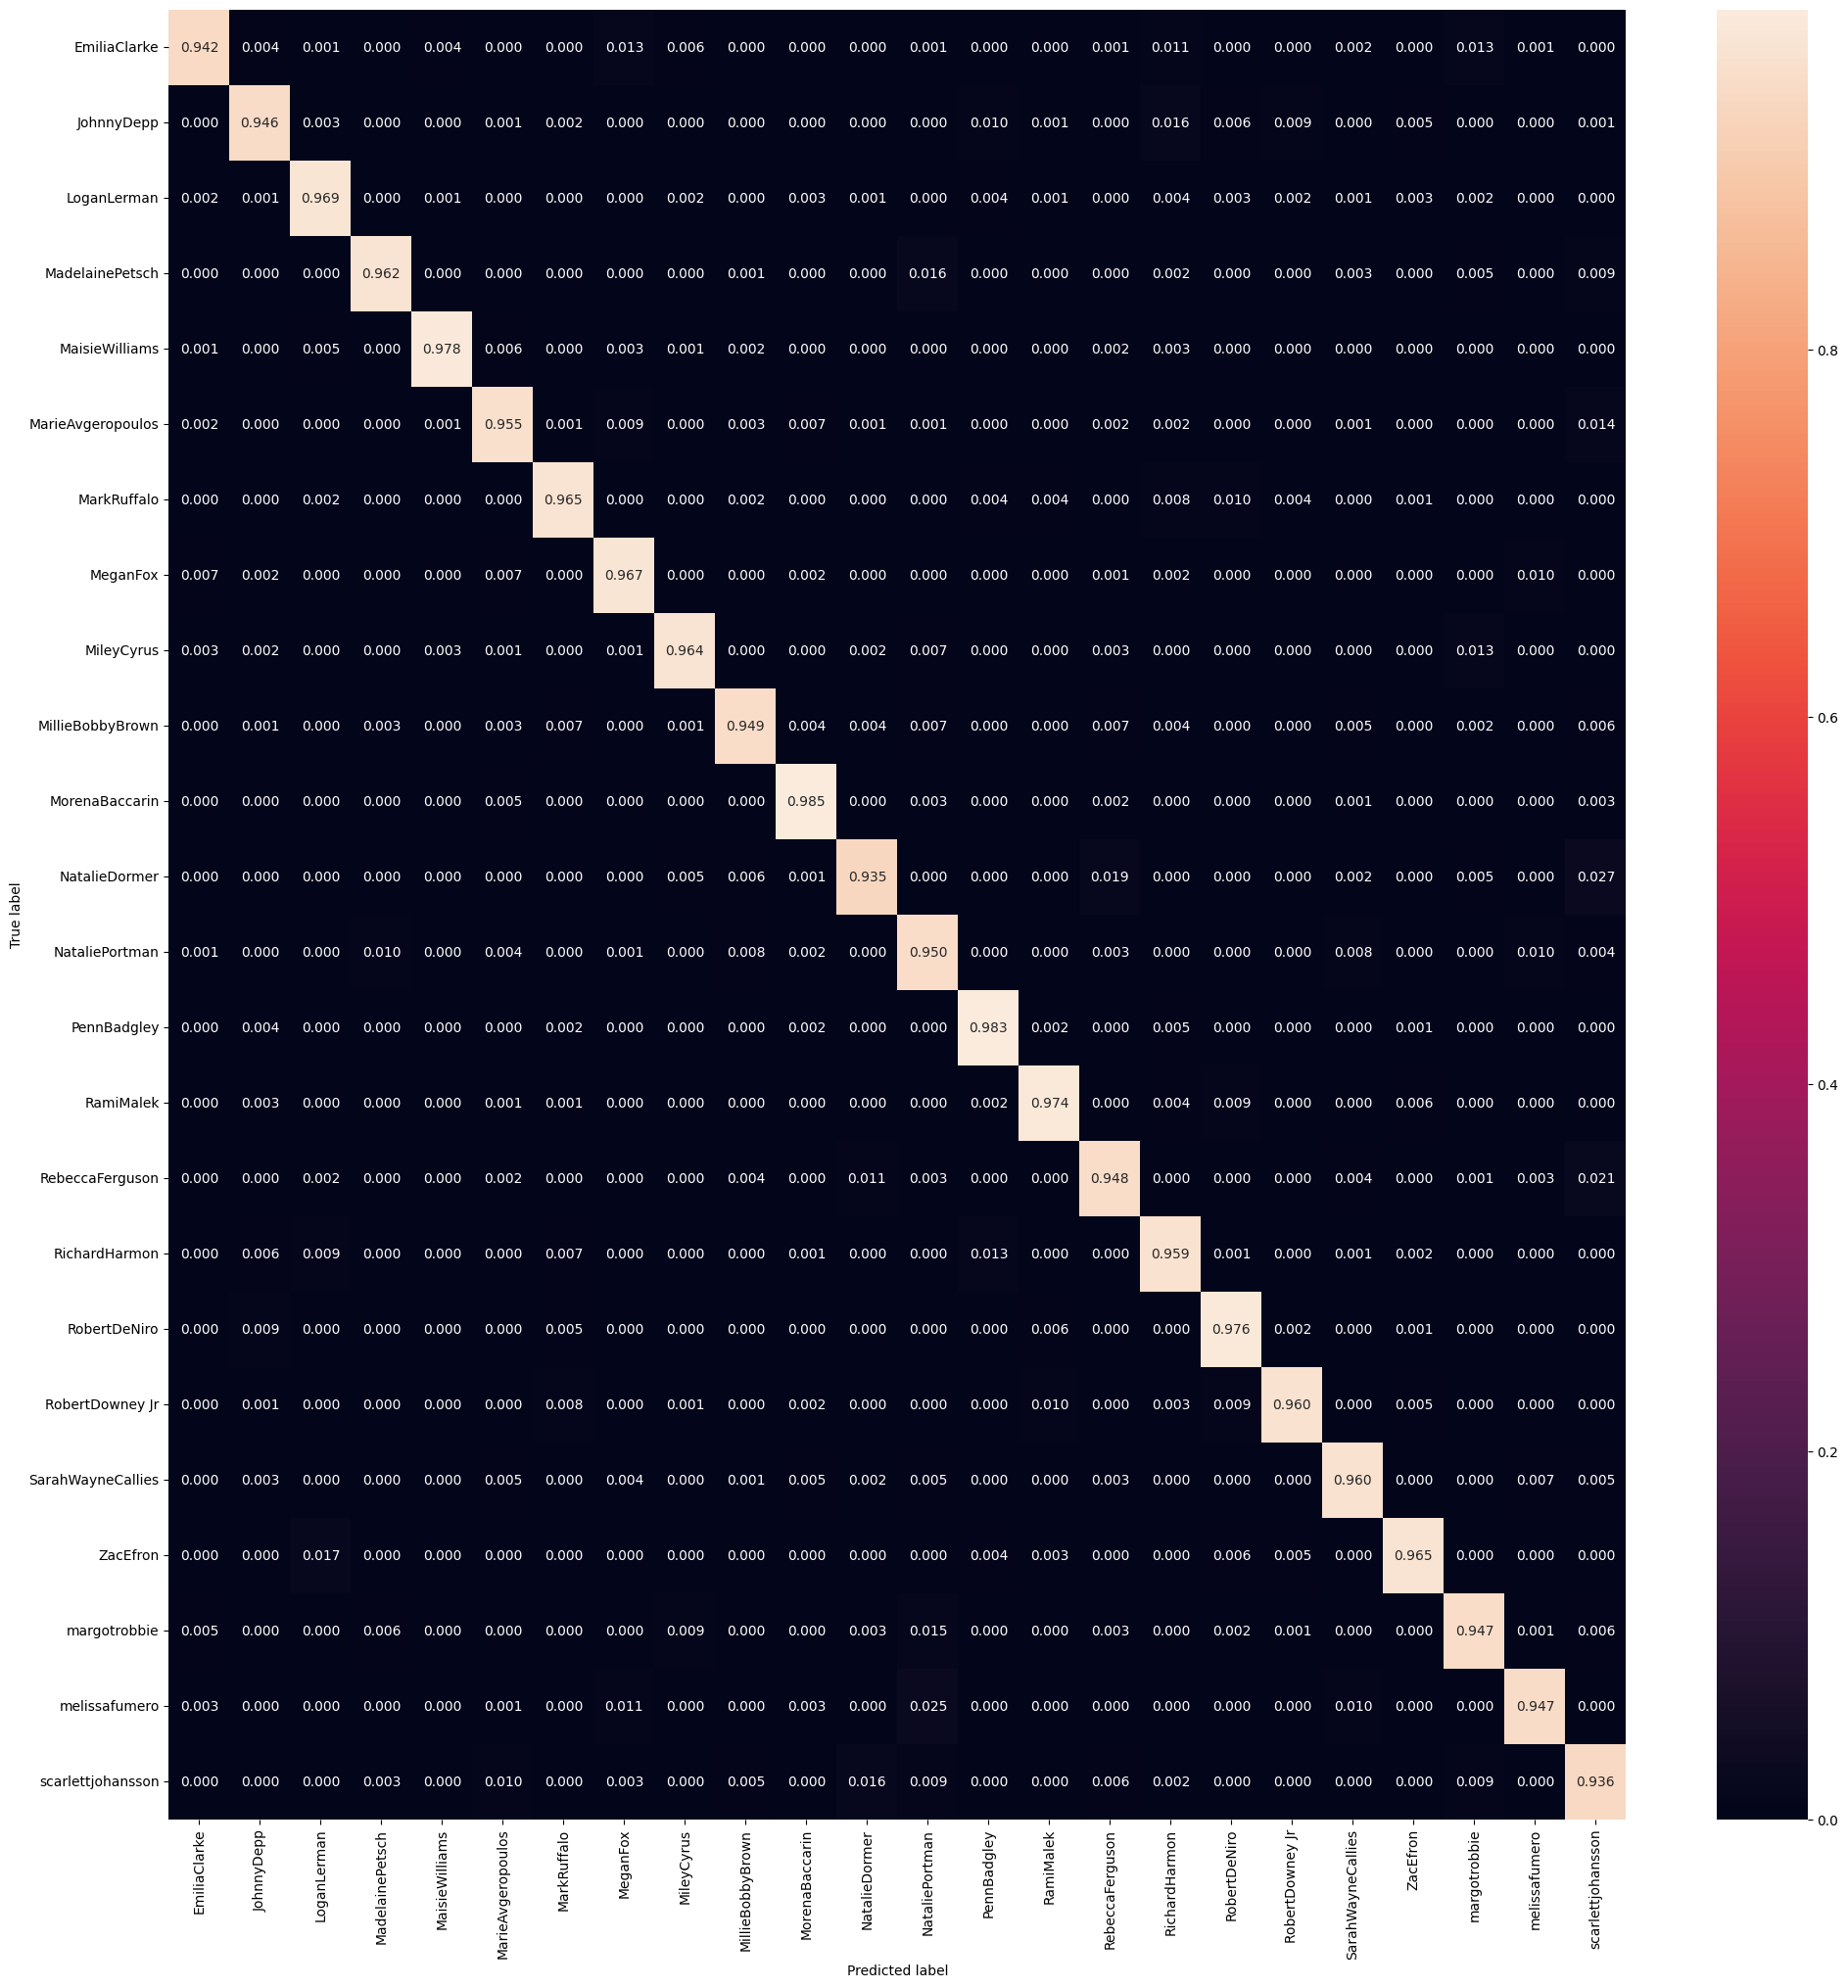

In [27]:
def plotConfMatrix(y_true, y_pred, classes, n_last_epochs = 24):
    if len(y_true)< n_last_epochs:
        n_last_epochs = len(y_true)

    y_true = np.array(y_true).flatten() #con flatten si appiattisce l'arrey, assicurandoci che y_pred e y_true sia entrambi di una dimensione
    y_pred = np.array(y_pred).flatten()
    cm = confusion_matrix(y_true, y_pred)

    #normalizzo la matrice per righe
    cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
    #cm.sum(axis=1)[i] rappresenta il numero totale di predizioni per la classe reale i.
    
    plt.figure(figsize=(len(classes),len(classes)))
    heatmap(cm, annot=True, fmt='.3f', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')# etichette reali sull'asse delle y
    plt.xlabel('Predicted label')# etichette predette sull'asse delle x
    plt.show()

y_true = np.load("true_labels_fold.npy")
y_pred = np.load("predicted_labels_fold.npy")
plotConfMatrix(y_true, y_pred, data_classes)

Genero anche il grafico che mette a confronto loss e accuracy con le varie epoche

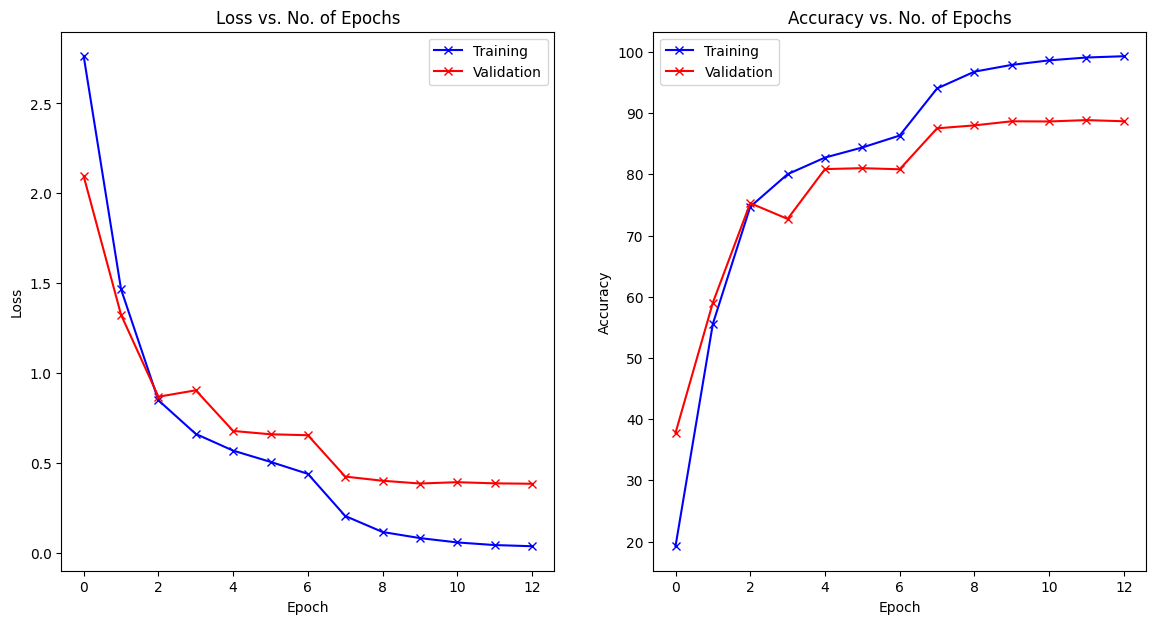

In [28]:
all_train_losses = np.load("train_losses_fold0.npy")
all_val_losses = np.load("val_losses_fold0.npy")
all_train_accuracies = np.load("train_accuracies_fold0.npy")
all_val_accuracies = np.load("val_accuracies_fold0.npy")

subplots, ax = plt.subplots(1,2, figsize=(14,7))
# Loss
ax[0].plot(all_train_losses, '-bx')
ax[0].plot(all_val_losses, '-rx')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training', 'Validation'])
ax[0].set_title('Loss vs. No. of Epochs')
# Accuracy
ax[1].plot(all_train_accuracies, '-bx')
ax[1].plot(all_val_accuracies, '-rx')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Training', 'Validation'])
ax[1].set_title('Accuracy vs. No. of Epochs')

plt.show()

In [29]:
torch.save(model.state_dict(), 'model_weights.pth') 


Carico il modello con i nuovi pesi calcolati

In [30]:
model = celebaCnnModel(num_classes=len(data_classes), inchannels=3)
model.load_state_dict(torch.load('model_weights.pth2')) #carico i pesi del modello
model = model.to(device)

#### **Fase di testing**

Testo il modello sul test set, stampando anche 20 immagini scelte casualmente

In [31]:
def test_model_and_display(model_loaded, dataset, data_classes, batchSize, device, num_images_to_display=20):
    model_loaded.eval()  # Imposta il modello in modalità di valutazione
    num_test_images = len(data_classes)

    # Crea il DataLoader per l'intero set di dati
    test_dl = DataLoader(dataset, batch_size=batchSize, shuffle=False)
    test_dl = DeviceDataloader(test_dl, device)  # Sposta i dati sulla GPU

    true_labs = []
    pred_labs = []
    images = []

    # Disabilita il calcolo del gradiente per la fase di test
    with torch.no_grad():
        for img, label in tqdm(test_dl, desc="Testing", unit="batch"):
            outputs = model_loaded(img)  # Esegui il modello sui dati di test
            _, predicted = torch.max(outputs, 1)  # Ottieni le predizioni
            
            # Estrai le etichette vere e le predizioni
            true_labs.extend(label.cpu().numpy())
            pred_labs.extend(predicted.cpu().numpy())
            images.extend(img.cpu())  # Salva le immagini per visualizzarle dopo

    # Calcola l'accuratezza
    accuracy = sum(np.array(true_labs) == np.array(pred_labs)) / len(true_labs) * 100
    print(f'Accuracy: {accuracy:.2f}%')

    # Seleziona casualmente 20 indici delle immagini da mostrare
    random_indices = random.sample(range(len(images)), num_images_to_display)

    # Visualizza le immagini selezionate
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        plt.subplot(4, 5, i + 1)  # Organizza in 4 righe e 5 colonne
        img = images[idx].permute(1, 2, 0).numpy()  # Cambia l'ordine dei canali da [C, H, W] a [H, W, C]
        plt.imshow(img)
        plt.title(f'True: {data_classes[int(true_labs[idx])]}\nPred: {data_classes[int(pred_labs[idx])]}' )
        plt.axis('off')  # Rimuovi gli assi per chiarezza
    plt.tight_layout()
    plt.show()


Testing: 100%|██████████| 92/92 [00:22<00:00,  4.16batch/s]


Accuracy: 89.77%


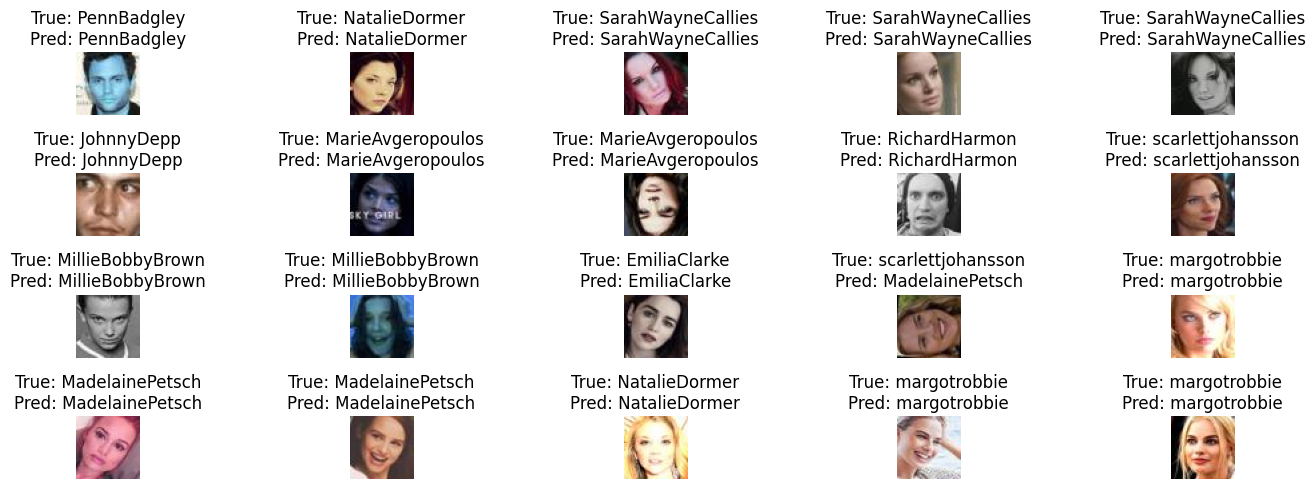

In [32]:
test_model_and_display(model, test_subset, data_classes, batchSize, device)